In [35]:
import pandas as pd

# โหลดข้อมูลจาก CSV
data = pd.read_csv("data/alldata.csv")




In [ ]:



print(data.shape)
data.drop_duplicates(subset=['title','city','country'], inplace=True)
print(data.shape)


(1378634, 8)
(46593, 8)


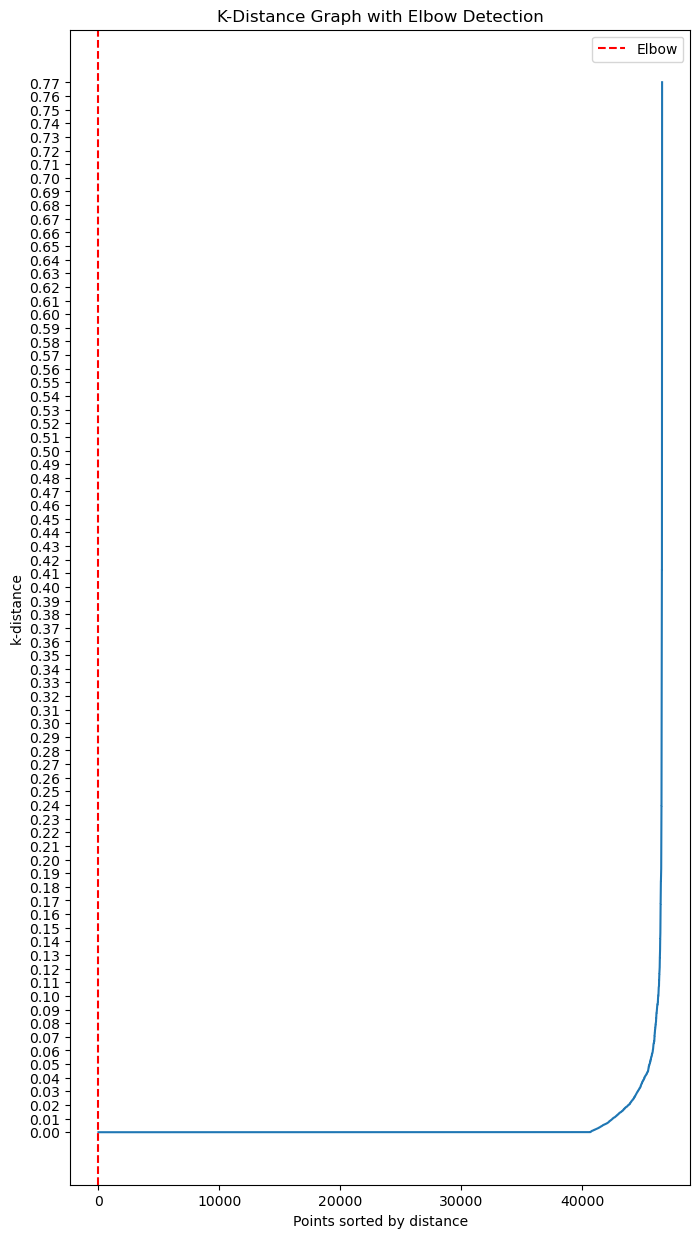

In [37]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# ใช้เฉพาะค่าพิกัดสำหรับ Clustering
coordinates = data[["latitude", "longitude"]]

# Standardize ข้อมูล
scaler = StandardScaler()
coordinates_scaled = scaler.fit_transform(coordinates)

neighbors = NearestNeighbors(n_neighbors=10)  # กำหนดจำนวน k
neighbors_fit = neighbors.fit(coordinates_scaled)
distances, indices = neighbors_fit.kneighbors(coordinates_scaled)

distances = np.sort(distances[:, -1])


plt.figure(figsize=(8, 15))
plt.plot(distances)
plt.axvline(x=np.argmin(np.diff(distances)), color='r', linestyle='--', label="Elbow")
plt.title('K-Distance Graph with Elbow Detection')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')

plt.yticks(np.arange(min(distances), max(distances), step=0.01))  # ปรับค่า step ตามความละเอียดที่ต้องการ

plt.legend()
plt.show()




In [ ]:
dbscan = DBSCAN(eps=0.035, min_samples=10)  # กำหนดค่า eps และ min_samples
clusters = dbscan.fit_predict(coordinates_scaled)

data["Cluster"] = clusters

print("ผลลัพธ์ของ Clustering:")
print(data)



ผลลัพธ์ของ Clustering:
                        author_name  \
0                C. Rujitharanawong   
7        Pakkaporn Rungruengkultorn   
9             Chonchanok Muangnapoh   
18               Narut Prasitlumkum   
21                Danaithep Limskul   
...                             ...   
1364883              Matrisciano A.   
1364884                   Kvočka D.   
1364885                 Talpur B.A.   
1364886                 Skryabin A.   
1364887                  Marupov I.   

                                               affiliation           city  \
0                                         Siriraj Hospital        Bangkok   
7                                 Chulalongkorn University        Bangkok   
9                 Mahidol University, Faculty of Dentistry        Bangkok   
18                     University of California, Riverside      Riverside   
21                    King Chulalongkorn Memorial Hospital        Bangkok   
...                                           

In [46]:
data['Cluster'].value_counts().head(15)

Cluster
 0      14768
 5       4589
 6       2899
 48      1807
 20      1691
-1       1448
 44      1237
 22       988
 19       892
 74       750
 104      499
 33       479
 126      468
 71       466
 3        426
Name: count, dtype: int64

In [47]:
data.to_csv('data/data_with_clustering.csv',index=False)

# Predict Cluster from Title

In this section, we will use the trained model to predict the cluster for a given title. The model has been trained using a pipeline that includes TF-IDF vectorization and a classifier. The following steps outline the process:

1. **Load the Model**: Load the pre-trained model from the saved file.
2. **Predict Cluster**: Use the model to predict the cluster for a new title.
3. **Inverse Transform**: Convert the predicted cluster label back to its original form using the label encoder.

```python
# Function to predict cluster from title
def predict_cluster(title):
    model = joblib.load('model/incremental_model.joblib')
    prediction = model.predict([title])
    return le.inverse_transform(prediction)

# Example usage
title_input = "Optimization in supply chain using RFID"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")
```

This function can be used to predict the cluster for any new title by simply passing the title as an argument to the `predict_cluster` function. The model will return the cluster to which the title belongs.

In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder
import pandas as pd
df = pd.read_csv('data/data_with_clustering.csv')
# Load the label encoder
le = LabelEncoder()
le.fit_transform(df['Cluster'])

In [53]:
data_filtered = df[df['Cluster'] != -1]

cluster_counts = data_filtered['Cluster'].value_counts()

clusters_to_keep = cluster_counts[cluster_counts > 1500].index

filtered_df = data_filtered[data_filtered['Cluster'].isin(clusters_to_keep)]

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_41360\2007021617.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", num_clusters)  # ใช้ "tab20" สำหรับชุดสี 20 สี


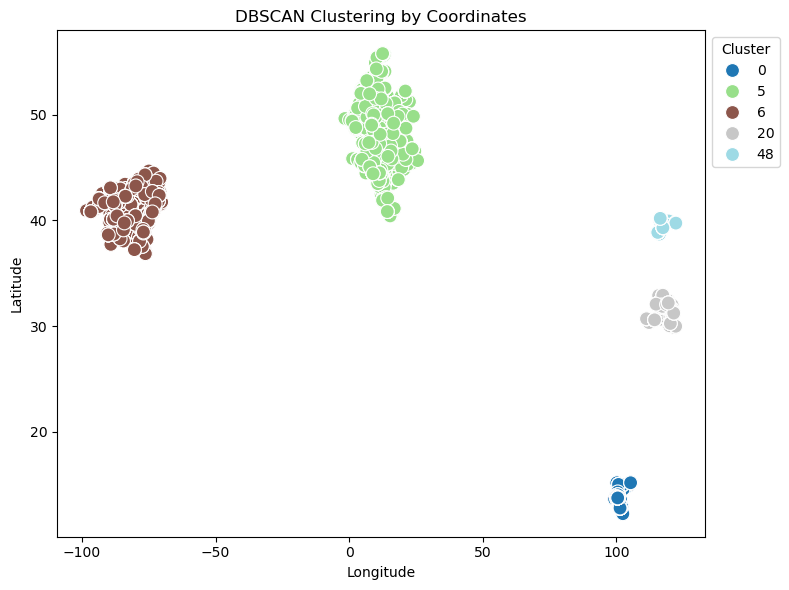

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




unique_clusters = filtered_df["Cluster"].unique()
num_clusters = len(unique_clusters)
cmap = plt.cm.get_cmap("tab20", num_clusters)
cluster_palette = {cluster: cmap(i) for i, cluster in enumerate(unique_clusters)}

# การแสดงกราฟ Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="longitude",
    y="latitude",
    hue="Cluster",
    palette=cluster_palette,  # ใช้ palette ที่กำหนดไว้
    data=filtered_df,  # ใช้ข้อมูลที่กรองแล้ว
    s=100
)
plt.title("DBSCAN Clustering by Coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [56]:
filtered_df['Cluster'].value_counts()

Cluster
0     14768
5      4589
6      2899
48     1807
20     1691
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

filtered_df['title'] = filtered_df['title'].apply(remove_stopwords)

le = LabelEncoder()
filtered_df['Cluster'] = le.fit_transform(filtered_df['Cluster'])

X = filtered_df['title']
y = filtered_df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3))
])

param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__max_iter': [1000, 1500, 2000]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=2, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with best parameters:", accuracy)

joblib.dump(grid_search.best_estimator_, 'model/grid_search_best_model.joblib')

def predict_cluster(title):
    model = joblib.load('model/grid_search_best_model.joblib')
    prediction = model.predict([title])
    return le.inverse_transform(prediction)

title_input = "Optimization in supply chain using RFID"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 2 folds for each of 243 candidates, totalling 486 fits


c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
162 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-pack

Best parameters found:  {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__max_iter': 1500, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1}
Accuracy with best parameters: 0.7477538185085355
The title belongs to cluster: 0


In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# ดาวน์โหลด stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ฟังก์ชั่นสำหรับลบ stopwords
def remove_stopwords(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# เตรียมข้อมูล (ตัวอย่าง)
# filtered_df คือ DataFrame ที่คุณมีอยู่แล้ว
df['title'] = df['title'].apply(remove_stopwords)

# การทำ Label Encoding
le = LabelEncoder()
df['Cluster'] = le.fit_transform(df['Cluster'])

# แยก Features และ Labels
X = df['title']
y = df['Cluster']

# แบ่งข้อมูลเป็น Training และ Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้าง pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3))
])

# กำหนดพารามิเตอร์ที่ต้องการทดสอบใน GridSearchCV
param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__max_iter': [1000, 1500, 2000]
}

# ใช้ GridSearchCV ในการค้นหาพารามิเตอร์ที่ดีที่สุด
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# เทรนโมเดลด้วย GridSearchCV
grid_search.fit(X_train, y_train)

# แสดงพารามิเตอร์ที่ดีที่สุด
print("Best parameters found: ", grid_search.best_params_)

# ทดสอบ accuracy ด้วยพารามิเตอร์ที่ดีที่สุด
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with best parameters:", accuracy)

# บันทึกโมเดลที่ดีที่สุด
joblib.dump(grid_search.best_estimator_, 'model/grid_search_best_model.joblib')

# ฟังก์ชั่นสำหรับพยากรณ์คลัสเตอร์
def predict_cluster(title):
    model = joblib.load('model/grid_search_best_model.joblib')
    prediction = model.predict([title])
    return le.inverse_transform(prediction)

# ตัวอย่างการพยากรณ์
title_input = "Optimization in supply chain using RFID"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PREDATOR\anaconda3\envs\dsde-cedt\Lib\site

Best parameters found:  {'clf__alpha': 0.0001, 'clf__loss': 'modified_huber', 'clf__max_iter': 1500, 'tfidf__max_df': 0.8, 'tfidf__min_df': 1}
Accuracy with best parameters: 0.3930679257431055
The title belongs to cluster: 1


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
import string
import nltk
from nltk.corpus import stopwords  # เพิ่มการ import stopwords

# โหลด stopwords จาก nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ฟังก์ชั่นสำหรับการตัดคำ stopwords
def remove_stopwords(text):
    # ตัดเครื่องหมายวรรคตอน
    text = ''.join([char for char in text if char not in string.punctuation])
    # แปลงข้อความเป็นตัวพิมพ์เล็กทั้งหมด
    text = text.lower()
    # ตัดคำ stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# เตรียมข้อมูล (ตัวอย่าง)
import pandas as pd


# เตรียมข้อมูล
filtered_df['title'] = filtered_df['title'].apply(remove_stopwords)

# การทำ Label Encoding สำหรับ Cluster
le = LabelEncoder()
filtered_df['Cluster'] = le.fit_transform(filtered_df['Cluster'])  # label encoding สำหรับ Cluster

# ข้อมูล Features และ Labels
X = filtered_df['title']  # ข้อความ (title)
y = filtered_df['Cluster']  # คลัสเตอร์ที่เกิดจาก DBSCAN

# แบ่งข้อมูลเป็น training set และ test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้าง pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.8)),  # แปลงข้อความเป็นเวกเตอร์
    ('clf', SVC(kernel='linear', C=1, gamma='scale', probability=True))  # ใช้ SVM กับ kernel แบบ linear
])

# ฝึกโมเดล
pipeline.fit(X_train, y_train)

# ทดสอบ accuracy
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# บันทึกโมเดล
joblib.dump(pipeline, 'model/model_with_stopwords_removed_without_thousand_again.joblib')

# ใช้โมเดลในการทำนาย cluster จากข้อความใหม่
def predict_cluster(title):
    model = joblib.load('model/model_with_stopwords_removed_without_thousand_again.joblib')
    prediction = model.predict([title])  # ทำนาย cluster จาก title
    return le.inverse_transform(prediction)  # แปลงผลลัพธ์กลับเป็น label เดิม

# ตัวอย่างการใช้ฟังก์ชั่น
title_input = "Enter your keyword or title here"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.7603324348607368
The title belongs to cluster: 0


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
import string
import nltk
from nltk.corpus import stopwords  # เพิ่มการ import stopwords

# โหลด stopwords จาก nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ฟังก์ชั่นสำหรับการตัดคำ stopwords
def remove_stopwords(text):
    # ตัดเครื่องหมายวรรคตอน
    text = ''.join([char for char in text if char not in string.punctuation])
    # แปลงข้อความเป็นตัวพิมพ์เล็กทั้งหมด
    text = text.lower()
    # ตัดคำ stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# เตรียมข้อมูล (ตัวอย่าง)
import pandas as pd


# เตรียมข้อมูล
df['title'] = df['title'].apply(remove_stopwords)

# การทำ Label Encoding สำหรับ Cluster
le = LabelEncoder()
df['Cluster'] = le.fit_transform(df['Cluster'])  # label encoding สำหรับ Cluster

# ข้อมูล Features และ Labels
X = df['title']  # ข้อความ (title)
y = df['Cluster']  # คลัสเตอร์ที่เกิดจาก DBSCAN

# แบ่งข้อมูลเป็น training set และ test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้าง pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.8)),  # แปลงข้อความเป็นเวกเตอร์
    ('clf', SVC(kernel='linear', C=1, gamma='scale', probability=True))  # ใช้ SVM กับ kernel แบบ linear
])

# ฝึกโมเดล
pipeline.fit(X_train, y_train)

# ทดสอบ accuracy
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# บันทึกโมเดล
joblib.dump(pipeline, 'model/model_with_stopwords_removed_without_thousand_again.joblib')

# ใช้โมเดลในการทำนาย cluster จากข้อความใหม่
def predict_cluster(title):
    model = joblib.load('model/model_with_stopwords_removed_without_thousand_again.joblib')
    prediction = model.predict([title])  # ทำนาย cluster จาก title
    return le.inverse_transform(prediction)  # แปลงผลลัพธ์กลับเป็น label เดิม

# ตัวอย่างการใช้ฟังก์ชั่น
title_input = "Enter your keyword or title here"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.3948921558107093
The title belongs to cluster: 0


In [66]:
title_input = "africa"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")

The title belongs to cluster: -1


In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# ดาวน์โหลด stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ฟังก์ชั่นสำหรับลบ stopwords
def remove_stopwords(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# เตรียมข้อมูล (ตัวอย่าง)
# filtered_df คือ DataFrame ที่คุณมีอยู่แล้ว
filtered_df['title'] = filtered_df['title'].apply(remove_stopwords)

# การทำ Label Encoding
le = LabelEncoder()
filtered_df['Cluster'] = le.fit_transform(filtered_df['Cluster'])

# แยก Features และ Labels
X = filtered_df['title']
y = filtered_df['Cluster']

# แบ่งข้อมูลเป็น Training และ Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้าง pipeline โดยใช้พารามิเตอร์ที่ดีที่สุดที่ได้จาก GridSearchCV
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.8, min_df=1)),  # ใช้ max_df=0.8 และ min_df=1 จากผลลัพธ์ของ GridSearchCV
    ('clf', SGDClassifier(loss='modified_huber', max_iter=2000, alpha=0.0001))  # ใช้ loss='modified_huber', max_iter=2000, alpha=0.0001
])

# เทรนโมเดลด้วย batch แรก
pipeline.fit(X_train, y_train)

# บันทึกโมเดล
joblib.dump(pipeline, 'model/incremental_model.joblib')

# ทดสอบ accuracy
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with best parameters:", accuracy)

# ฟังก์ชั่นสำหรับเพิ่มข้อมูลใหม่และอัปเดตโมเดล
def incremental_training(new_X, new_y):
    # โหลดโมเดลที่บันทึกไว้
    model = joblib.load('model/incremental_model.joblib')
    
    # อัปเดตโมเดลด้วยข้อมูลใหม่
    model.named_steps['clf'].partial_fit(
        model.named_steps['tfidf'].transform(new_X),  # แปลงข้อมูลใหม่เป็นเวกเตอร์
        new_y,
        classes=np.unique(y)  # ระบุคลาสทั้งหมด
    )
    
    # บันทึกโมเดลที่อัปเดตแล้ว
    joblib.dump(model, 'model/incremental_model.joblib')
    print("Model updated with new data.")

# ตัวอย่างการเพิ่มข้อมูลใหม่
new_data_X = ["New research about RFID technology"]  # ตัวอย่าง title ใหม่
new_data_y = [0]  # คลัสเตอร์ของ title ใหม่
incremental_training(new_data_X, new_data_y)

# ใช้โมเดลในการพยากรณ์คลัสเตอร์
def predict_cluster(title):
    model = joblib.load('model/incremental_model.joblib')
    prediction = model.predict([title])
    return le.inverse_transform(prediction)

# ตัวอย่างการพยากรณ์
title_input = "Optimization in supply chain using RFID"
predicted_cluster = predict_cluster(title_input)
print(f"The title belongs to cluster: {predicted_cluster[0]}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PREDATOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_49184\4291513547.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title'] = filtered_df['title'].apply(remove_stopwords)
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_49184\4291513547.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = le.fit_transform(filte

Accuracy with best parameters: 0.6391420159820552
Model updated with new data.
The title belongs to cluster: 0
